In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('linear_regression_adv').getOrCreate()

# If you're getting an error with numpy, please type 'sudo pip install numpy --user' into the EC2 console.
from pyspark.ml.regression import LinearRegression

In [2]:
data = spark.read.csv("Data/finalmergedlog10.csv",inferSchema=True,header=True)
data.show()

+----+-------------------+--------------------+---------------------+--------------------------+-----------------------------+---------------+----------------+-------------+--------------+-----------+------------+----------+-----------+----------------------------------+-----------------------------------------------------+
|Year|United States Total|United States 1 Unit|United States 2 Units|United States 3 to 4 units|United States 5 Units or More|Northeast Total|Northeast 1 Unit|Midwest Total|Midwest 1 Unit|South Total|South 1 Unit|West Total|West 1 Unit|HONEY - PRODUCTION, MEASURED IN LB|HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES|
+----+-------------------+--------------------+---------------------+--------------------------+-----------------------------+---------------+----------------+-------------+--------------+-----------+------------+----------+-----------+----------------------------------+-----------------------------------------------------+
|1990|             111

In [3]:
data.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- United States Total: double (nullable = true)
 |-- United States 1 Unit: double (nullable = true)
 |-- United States 2 Units: double (nullable = true)
 |-- United States 3 to 4 units: double (nullable = true)
 |-- United States 5 Units or More: double (nullable = true)
 |-- Northeast Total: double (nullable = true)
 |-- Northeast 1 Unit: double (nullable = true)
 |-- Midwest Total: double (nullable = true)
 |-- Midwest 1 Unit: double (nullable = true)
 |-- South Total: double (nullable = true)
 |-- South 1 Unit: double (nullable = true)
 |-- West Total: double (nullable = true)
 |-- West 1 Unit: double (nullable = true)
 |-- HONEY - PRODUCTION, MEASURED IN LB: double (nullable = true)
 |-- HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES: double (nullable = true)



In [4]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [5]:
assembler = VectorAssembler(
    inputCols=["United States Total", "United States 1 Unit","United States 2 Units", "United States 3 to 4 units",
              "United States 5 Units or More", "Northeast Total", "Northeast 1 Unit", "Midwest Total", "Midwest 1 Unit",
              "South Total", "South 1 Unit", "West Total", "West 1 Unit"],
    outputCol="features")

In [6]:
output = assembler.transform(data)

In [7]:
output.printSchema()


root
 |-- Year: integer (nullable = true)
 |-- United States Total: double (nullable = true)
 |-- United States 1 Unit: double (nullable = true)
 |-- United States 2 Units: double (nullable = true)
 |-- United States 3 to 4 units: double (nullable = true)
 |-- United States 5 Units or More: double (nullable = true)
 |-- Northeast Total: double (nullable = true)
 |-- Northeast 1 Unit: double (nullable = true)
 |-- Midwest Total: double (nullable = true)
 |-- Midwest 1 Unit: double (nullable = true)
 |-- South Total: double (nullable = true)
 |-- South 1 Unit: double (nullable = true)
 |-- West Total: double (nullable = true)
 |-- West 1 Unit: double (nullable = true)
 |-- HONEY - PRODUCTION, MEASURED IN LB: double (nullable = true)
 |-- HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES: double (nullable = true)
 |-- features: vector (nullable = true)



In [8]:
final_data = output.select("features","HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES")
final_data.show()

+--------------------+-----------------------------------------------------+
|            features|HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES|
+--------------------+-----------------------------------------------------+
|[1110.8,793.9,26....|                                    6.507855871695831|
|[948.8,753.5,22.0...|                                    6.506640305566503|
|[1094.9,910.7,23....|                                    6.483587296968894|
|[1199.1,986.5,26....|                                    6.458637849025649|
|[1371.6,1068.5,31...|                                    6.444513206334043|
|[1332.5,997.3,32....|                                    6.424064525417488|
|[1425.6,1069.5,33...|                                    6.411788004543869|
|[1441.1,1062.4,34...|                                    6.420120848085703|
|[1612.3,1187.6,33...|                                    6.421110129793434|
|[1663.5,1246.7,32...|                                    6.423573519732735|

In [13]:
train_data,test_data = final_data.randomSplit([0.7,0.3])

In [14]:
train_data.describe().show()

test_data.describe().show()

+-------+-----------------------------------------------------+
|summary|HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES|
+-------+-----------------------------------------------------+
|  count|                                                   19|
|   mean|                                    6.429455280884437|
| stddev|                                  0.03280818594933362|
|    min|                                    6.369586890736344|
|    max|                                    6.507855871695831|
+-------+-----------------------------------------------------+

+-------+-----------------------------------------------------+
|summary|HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES|
+-------+-----------------------------------------------------+
|  count|                                                   12|
|   mean|                                     6.41979976311421|
| stddev|                                  0.03293520044942882|
|    min|                              

In [15]:
lr = LinearRegression(labelCol='HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES')

In [16]:
lrModel = lr.fit(train_data)

In [17]:
print("Coefficients: {} Intercept: {}".format(lrModel.coefficients,lrModel.intercept))

Coefficients: [-0.1403076018014581,-0.07608017834858494,0.06997143642916658,0.06689757231906211,0.07076003416553206,0.06956368943251602,0.14734469468612832,0.0682664446255741,0.1487240211795308,0.06874313472612306,0.14753541901984393,0.07158800530285687,0.14497171091584213] Intercept: 6.421053816517499


In [18]:
test_results = lrModel.evaluate(test_data)

In [19]:
test_results.residuals.show()

print("RSME: {}".format(test_results.rootMeanSquaredError))

+--------------------+
|           residuals|
+--------------------+
|-0.00815579156850...|
|-0.00731271495716...|
|0.030759366958798218|
|5.095707087932055E-4|
|-0.01301090133440...|
|-0.04131417772725854|
|0.026340362079839252|
|-0.01833266993148...|
|-0.00793383005543...|
|-0.01862321045561...|
|-0.04060006522362958|
|-0.02699191617669...|
+--------------------+

RSME: 0.023733127010518912


In [20]:
# We can also get the R2 value. 
print("R2: {}".format(test_results.r2))

R2: 0.43352875956897674


In [39]:
final_data.describe().show()

+-------+-----------------------------------------------------+
|summary|HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES|
+-------+-----------------------------------------------------+
|  count|                                                   31|
|   mean|                                    6.425717661102416|
| stddev|                                   0.0326560220686697|
|    min|                                    6.369586890736344|
|    max|                                    6.507855871695831|
+-------+-----------------------------------------------------+



                                             features  \
0   [1110.8, 793.9, 26.7, 27.6, 262.6, 125.8, 96.5...   
1   [948.8, 753.5, 22.0, 21.1, 152.1, 109.8, 91.8,...   
2   [1094.9, 910.7, 23.3, 22.5, 138.4, 124.8, 108....   
3   [1199.1, 986.5, 26.7, 25.6, 160.2, 133.5, 113....   
4   [1371.6, 1068.5, 31.4, 30.8, 241.0, 138.5, 119...   
5   [1332.5, 997.3, 32.2, 31.5, 271.5, 124.2, 104....   
6   [1425.6, 1069.5, 33.6, 32.2, 290.3, 136.9, 108...   
7   [1441.1, 1062.4, 34.9, 33.6, 310.3, 141.9, 111...   
8   [1612.3, 1187.6, 33.2, 36.0, 355.5, 159.4, 124...   
9   [1663.5, 1246.7, 32.5, 33.3, 351.1, 164.9, 127...   
10  [1592.3, 1198.1, 30.6, 34.3, 329.3, 165.1, 122...   
11  [1636.7, 1235.6, 31.8, 34.2, 335.2, 159.8, 117...   
12  [1747.7, 1332.6, 37.2, 36.5, 341.4, 173.7, 126...   
13  [1889.2, 1460.9, 40.9, 41.6, 345.8, 182.4, 124...   
14  [2070.1, 1613.4, 43.0, 47.4, 366.2, 197.0, 131...   
15  [2155.3, 1682.0, 39.3, 44.7, 389.3, 203.8, 126...   
16  [1838.9, 1378.2, 35.3, 41.3

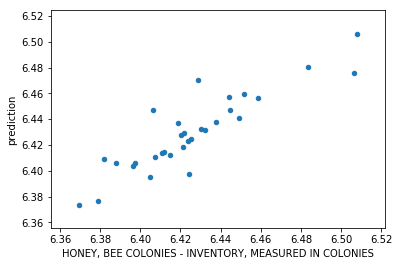

In [22]:
import matplotlib.pyplot as plt


rfPred = lrModel.transform(final_data)
rfResult = rfPred.toPandas()

print(rfResult)

rfResult.plot.scatter(x='HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES', y='prediction', style='o')